<div style="border:solid Chocolate 2px; padding: 40px">

Привет, меня зовут Александр Куимов. Я буду ревьюером твоего проекта. Ты можешь обращаться ко мне на "ты"😏 Надеюсь, тебя также не смутит, если я буду обращаться к тебе на "ты", но если это неудобно, обязательно скажи об этом!

Пожалуйста, не удаляй мои комментарии, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 

Ты также можешь реагировать на мои комментарии своими по шаблону, показанному чуть ниже. Это нужно, чтобы не создавалась путаница😉

Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> В случае, если решение на отдельном шаге является полностью правильным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> В случае, когда решение на отдельном шаге станет еще лучше, если внести небольшие коррективы.
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
 В случае, когда решение на отдельном шаге требует существенной переработки и внесения правок. Напоминаю, что проект не может быть принят с первого раза, если ревью содержит комментарии, рекомендующие доработать шаги.
</div>
    
    
<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> В такой цветовой ячейке я прошу тебя оставлять свои комментарии. Если исправляешь проект на второй итерации и выше, не забывай пожалуйста указывать номер итерации, например, "Комментарий студента v.2".
</div> 

<br/>    
    
Увидев у тебя неточность, в первый раз я лишь укажу на ее наличие и дам тебе возможность самому найти и исправить ее. На реальной работе твой руководитель будет поступать также, и я пытаюсь подготовить тебя именно к работе датасаентистом. Но если ты пока не справишься с такой задачей - при следующей проверке я дам более точную подсказку!🤓

# Сборный проект 2

## Введение

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Существует две задачи:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Вижу твое добавленное описание проекта. Молодец! Это поможет тебе расставлять акценты в выводах

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [1]:
!pip install -q phik


<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера 0 <a class="tocSkip"> </h2> 

Я вижу, что исполнение кода начинается в ячейке с номером, который отличается от единицы. Перед отправкой проекта стоит проверять работоспособность кода — это можно сделать, нажав на панели Jupiter Hub ``Kernel`` и ``Restart & Run All`` (см скриншот ниже).

![](https://i.postimg.cc/yd19rYf6/Screenshot-428.png)
        
Важно также убедиться, что все ячейки проекта исполнились - можно просто пролистать работу до конца и убедиться, что последняя ячейка исполнена. Такая проверка поможет тебе убедиться, что твоё решение будет должным образом воспроизведено во время ревью или во время передачи его заказчику - это очень важный этап, пренебрегать которым не стоит)
    
На втором сборном проекте воспроизводимость - это жёсткий критерий, поэтому убедись, пожалуйста, что проект работает, чтобы мы могли продолжить работу над ним

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', -1)
from sklearn.svm import SVC, SVR
matplotlib_axes_logger.setLevel('ERROR')
RANDOM_STATE = 42
TEST_SIZE = 0.25
sns.set()

In [3]:
df_train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
display(df_train_job_satisfaction_rate.head(5))
df_train_job_satisfaction_rate.info()

df_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
display(df_test_features.head(5))
df_test_features.info()

df_test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
display(df_test_target_job_satisfaction_rate.head(5))
df_test_target_job_satisfaction_rate.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Добавил Выводы по результатам осмотра данных v.2".
</div>

Выводы по результатам осмотра данных:
- в таблицах df_train_job_satisfaction_rate, df_test_features и df_test_target_job_satisfaction_rate присутствует колонка id, которая является идентификатором клиента а также ряд полей тпа int, float, object
- в таблицах df_train_job_satisfaction_rate, df_test_features есть небольшое количество пропусков (NaN или null) в определенных колонках
- название полей при импорте из файла сформированы латиницей snake case - и не требуют переименования
- типы колонок соответствуют их содержимомму - но возможно далее надо будет перевести тип object в string для большей компактности

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера  <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>


В  конце шага осмотра данных нужно написать развёрнутые выводы по результатам осмотра данных


### Предобработка данных

Произведена проверка на дубликаты по столбцу id для всех трех датафреймов - дубликатов нет

In [4]:
print(f'Количество дубликтов: df_train_job_satisfaction_rate: {df_train_job_satisfaction_rate.duplicated(subset="id").sum()},'
      f'df_test_features: {df_test_features.duplicated(subset="id").sum()},'
      f'df_test_target_job_satisfaction_rate: {df_test_target_job_satisfaction_rate.duplicated(subset="id").sum()}')


Количество дубликтов: df_train_job_satisfaction_rate: 0,df_test_features: 0,df_test_target_job_satisfaction_rate: 0


В датафреймах df_train_job_satisfaction_rate и df_test_features обнаружены NULL значения для колонок:
- dept
- level

Так как это категориальные переменные, то сначала надо произвести вывод всех значений которое принимает каждый параметр

In [5]:
display(df_train_job_satisfaction_rate['dept'].value_counts(dropna = False))
display(df_train_job_satisfaction_rate['level'].value_counts(dropna = False))
display(df_train_job_satisfaction_rate['workload'].value_counts())

display(df_test_features['dept'].value_counts(dropna = False))
display(df_test_features['level'].value_counts(dropna = False))

display(df_test_features['workload'].value_counts())


sales         1512
technology    866 
purchasing    610 
marketing     550 
hr            456 
NaN           6   
Name: dept, dtype: int64

junior    1894
middle    1744
sinior    358 
NaN       4   
Name: level, dtype: int64

medium    2066
low       1200
high      734 
Name: workload, dtype: int64

sales         763
technology    455
marketing     279
purchasing    273
hr            227
NaN           2  
              1  
Name: dept, dtype: int64

junior    974
middle    854
sinior    171
NaN       1  
Name: level, dtype: int64

medium    1043
low       593 
high      363 
          1   
Name: workload, dtype: int64

Обнаружена еще одна проблема во входных данных - в колонках df_test_features['dept'], df_test_features['workload'] имеется одно значение с категорией пробел. Очевидно, что это ошибка ввода данных и она в данном случае приравнивается к NaN.
Так как количество строкс с NaN или ' ' для этих параметров крайне мало по сравнению с общим количеством строк и нет явного значения, на которое можно заменить NaN или пробел (так как это категориальные параметры) то я предлагаю строки с NaN и пробелом удалить из этих датафреймов

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Я  убрал отсюда метод удаления NaN и ниже добавлю в Pipeline SimpleImputer(strategy='most_frequent') для категориальных полей v.2".
</div>

In [6]:
#df_train_job_satisfaction_rate = df_train_job_satisfaction_rate.dropna()
#df_train_job_satisfaction_rate.info()

#df_test_features = df_test_features.dropna()
#df_test_features.info()

display(df_test_features['dept'].value_counts())
df_test_features.drop(df_test_features[df_test_features['dept'] == ' '].index, inplace = True)
display(df_test_features['dept'].value_counts())
display(df_test_features['workload'].value_counts())
df_test_features.drop(df_test_features[df_test_features['workload'] == ' '].index, inplace = True)
display(df_test_features['workload'].value_counts())

sales         763
technology    455
marketing     279
purchasing    273
hr            227
              1  
Name: dept, dtype: int64

sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64

medium    1042
low       593 
high      363 
          1   
Name: workload, dtype: int64

medium    1042
low       593 
high      363 
Name: workload, dtype: int64

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b>
    
Аномалия обработана корректно. В целом она могла бы быть обработана и в `Pipeline`, при настройке энкодеров на обработку новых значений признаков, которые не были на момент обучения энкодера.
    

Кроме того, надо провалидировать значения оставшихся кат параметров

In [7]:
display(df_train_job_satisfaction_rate['workload'].value_counts())
display(df_train_job_satisfaction_rate['last_year_promo'].value_counts())
display(df_train_job_satisfaction_rate['last_year_violations'].value_counts())
display(df_test_features['workload'].value_counts())
display(df_test_features['last_year_promo'].value_counts())
display(df_test_features['last_year_violations'].value_counts())



medium    2066
low       1200
high      734 
Name: workload, dtype: int64

no     3880
yes    120 
Name: last_year_promo, dtype: int64

no     3441
yes    559 
Name: last_year_violations, dtype: int64

medium    1042
low       593 
high      363 
Name: workload, dtype: int64

no     1935
yes    63  
Name: last_year_promo, dtype: int64

no     1736
yes    262 
Name: last_year_violations, dtype: int64

С этими значениями все нормально - опечаток и ошибок при вводе нет

В значении 'sinior' для колонки level для датафреймов df_train_job_satisfaction_rate и df_test_features допущена грамматическая ошибка - но она допущена везде, где используется это значение - написано как *sinior*.  Предлагаю везде исправить на *senior*

In [8]:
df_train_job_satisfaction_rate['level'] = df_train_job_satisfaction_rate['level'].replace('sinior', 'senior')
display(df_train_job_satisfaction_rate['level'].value_counts(dropna = False))
df_test_features['level'] = df_test_features['level'].replace('sinior', 'senior')
display(df_test_features['level'].value_counts(dropna = False))

junior    1894
middle    1744
senior    358 
NaN       4   
Name: level, dtype: int64

junior    973
middle    853
senior    171
NaN       1  
Name: level, dtype: int64

Необходимо изменить тип "object" на "string" для всех колонок типа *object*

In [9]:
df_train_job_satisfaction_rate_str_col_list = df_train_job_satisfaction_rate.select_dtypes(exclude=np.number).columns
df_train_job_satisfaction_rate[df_train_job_satisfaction_rate_str_col_list] = \
  df_train_job_satisfaction_rate[df_train_job_satisfaction_rate_str_col_list].astype('string')
df_train_job_satisfaction_rate.info()

df_test_features_str_col_list = df_test_features.select_dtypes(exclude=np.number).columns
df_test_features[df_test_features_str_col_list] = \
  df_test_features[df_test_features_str_col_list].astype('string')
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   string 
 2   level                  3996 non-null   string 
 3   workload               4000 non-null   string 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   string 
 6   last_year_violations   4000 non-null   string 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), string(5)
memory usage: 312.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  -----

Колонки employment_years и supervisor_evaluation для test и train датафреймов надо перевести в категориальный формат, так как их значения представляют собой целые числа и они занимают отоносительно небольшой диапазон

In [10]:
df_train_job_satisfaction_rate[['employment_years', 'supervisor_evaluation']] = \
  df_train_job_satisfaction_rate[['employment_years', 'supervisor_evaluation']].astype('string')
df_train_job_satisfaction_rate.info()

df_test_features[['employment_years', 'supervisor_evaluation']] = \
  df_test_features[['employment_years', 'supervisor_evaluation']].astype('string')
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   string 
 2   level                  3996 non-null   string 
 3   workload               4000 non-null   string 
 4   employment_years       4000 non-null   string 
 5   last_year_promo        4000 non-null   string 
 6   last_year_violations   4000 non-null   string 
 7   supervisor_evaluation  4000 non-null   string 
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(2), string(7)
memory usage: 312.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  -----

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>
    
Именно в этом шаге заказчик требует обработать пропуски: использовать реализованные инструменты из библиотек (например, SimpleImputer). Исправь пожалуйста.
    
    
Заранее предостерегу, чтобы не было утечки в тестовую выборку ранее обученный пайплайн следует распространить методом `transform` на тестовую выборку.

### Исследовательский анализ данных

Построим гистограммы и boxplots для количественных параметров и pie диаграммы для категориальных

,id,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000
mean,544957.621000,33926.700000,0.533995
std,257883.104622,14900.703838,0.225327
min,100954.000000,12000.000000,0.030000
25%,322836.750000,22800.000000,0.360000
50%,534082.500000,30000.000000,0.560000
75%,771446.000000,43200.000000,0.710000
max,999521.000000,98400.000000,1.000000


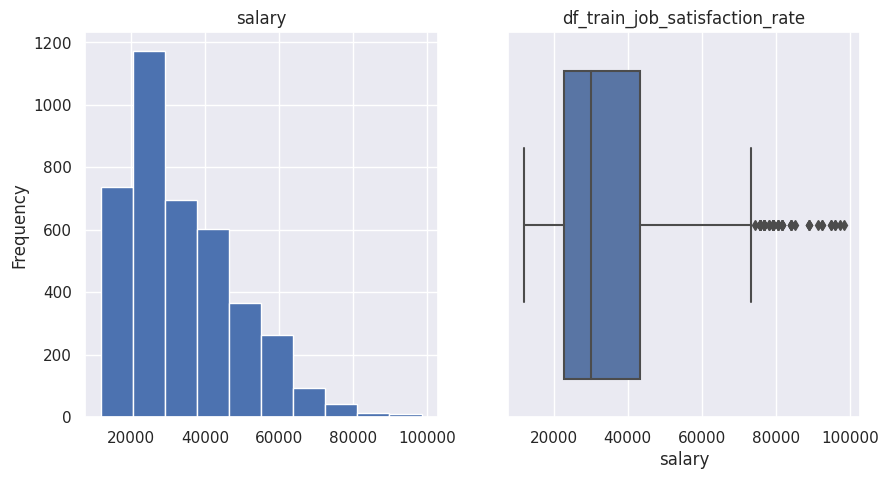

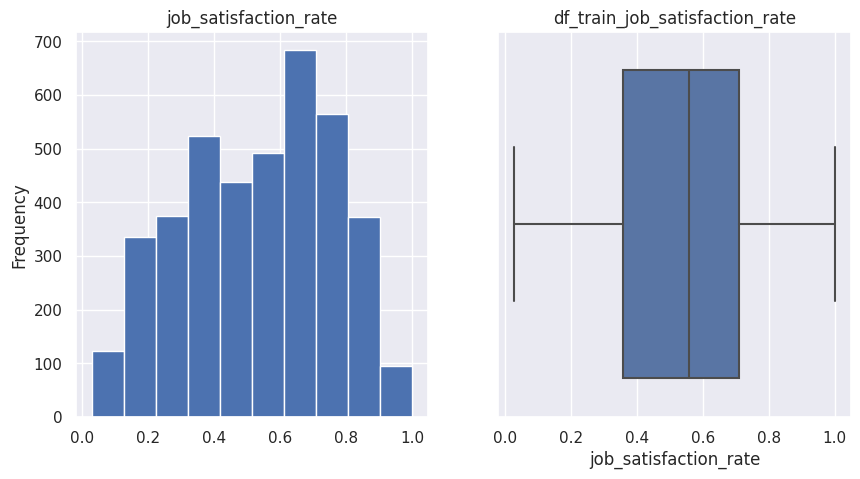

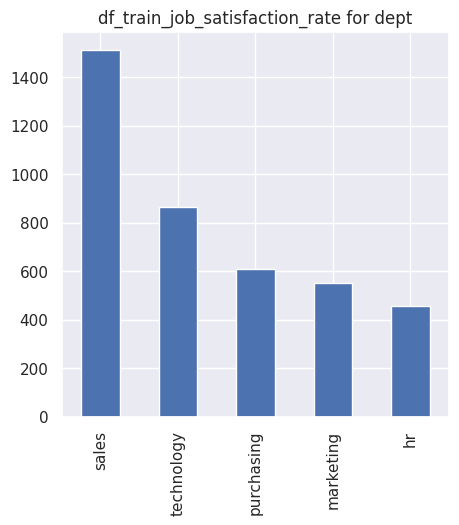

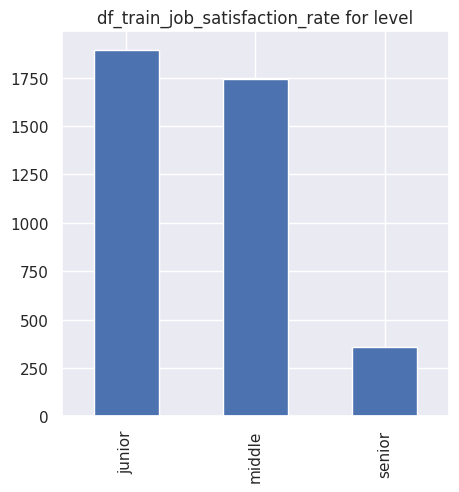

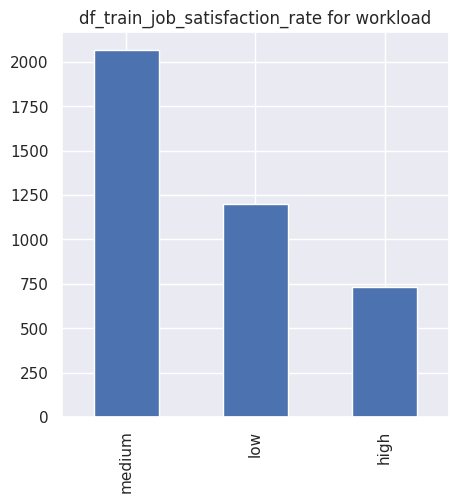

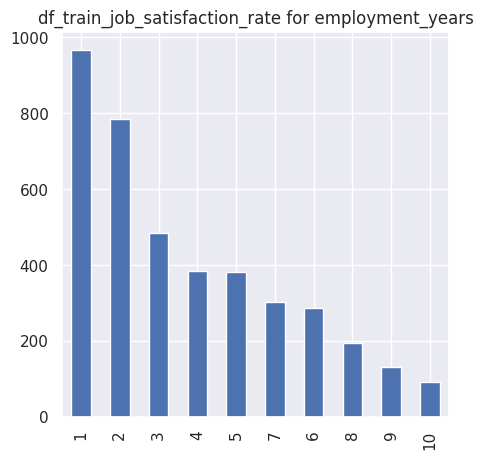

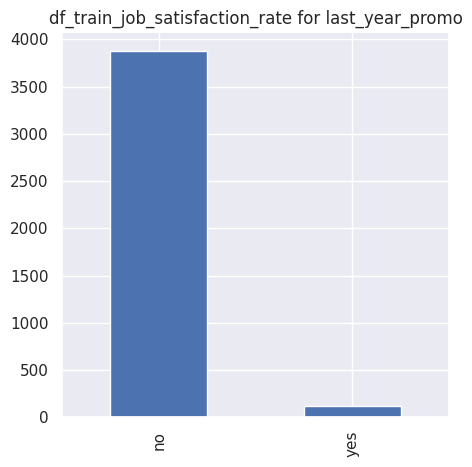

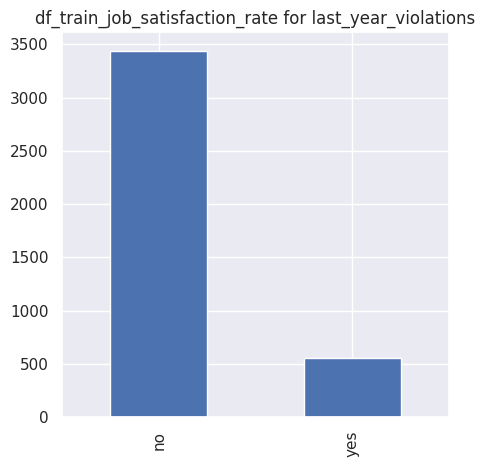

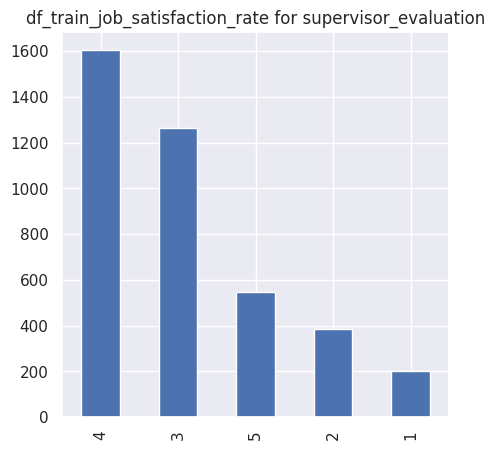

In [11]:
display(df_train_job_satisfaction_rate.describe())

def plot_sub_plot_hist_boxplot(df, title):
    for col in df.columns:
        if col == 'id':
            continue
        fig, axes = plt.subplots(nrows=1, ncols=2)
        df[col].plot(kind="hist", title=col, figsize=(10, 5), ax = axes[0])
        sns.boxplot(df[col], ax = axes[1])
        plt.title(title)
        plt.show()

def plot_pie_plot_for_columns(df, title):
    for col in df.columns:
        df[col].value_counts().plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, figsize=(5,5), title=col);
        plt.title(f'{title} for {col}')
        plt.show()

def plot_bar_plot_for_columns(df, title, normalizer = 1):
    for col in df.columns:
        ax = df[col].value_counts().plot(kind='bar',  label='',  figsize=(5,5), title=col);
        plt.title(f'{title} for {col}')
        if normalizer != 1:
          vals = ax.get_yticks()
          ax.set_yticklabels(['{:,.0%}'.format(x / normalizer) for x in vals])
        plt.show()

plot_sub_plot_hist_boxplot(df_train_job_satisfaction_rate.select_dtypes(include=np.number), 'df_train_job_satisfaction_rate')
plot_bar_plot_for_columns(df_train_job_satisfaction_rate.select_dtypes(exclude=np.number), 'df_train_job_satisfaction_rate')


Я не вижу явных выбросов для количественных параметров. Распределение целевой переменной job_satisfaction_rate похоже на нормальное, mean ~ median, выбросов нет.

,dept,employment_years,job_satisfaction_rate,last_year_promo,last_year_violations,level,salary,supervisor_evaluation,workload
dept,1.000000,0.037853,0.082086,0.000000,0.000000,0.000000,0.282265,0.105495,0.016509
employment_years,0.037853,1.000000,0.325603,0.183579,0.056808,0.682773,0.483419,0.000000,0.181941
job_satisfaction_rate,0.082086,0.325603,1.000000,0.190803,0.560348,0.080620,0.165830,0.764364,0.056128
last_year_promo,0.000000,0.183579,0.190803,1.000000,0.000000,0.101613,0.215025,0.013681,0.058663
last_year_violations,0.000000,0.056808,0.560348,0.000000,1.000000,0.000000,0.010078,0.182042,0.000000
level,0.000000,0.682773,0.080620,0.101613,0.000000,1.000000,0.717630,0.000000,0.419114
salary,0.282265,0.483419,0.165830,0.215025,0.010078,0.717630,1.000000,0.000000,0.788820
supervisor_evaluation,0.105495,0.000000,0.764364,0.013681,0.182042,0.000000,0.000000,1.000000,0.037023
workload,0.016509,0.181941,0.056128,0.058663,0.000000,0.419114,0.788820,0.037023,1.000000


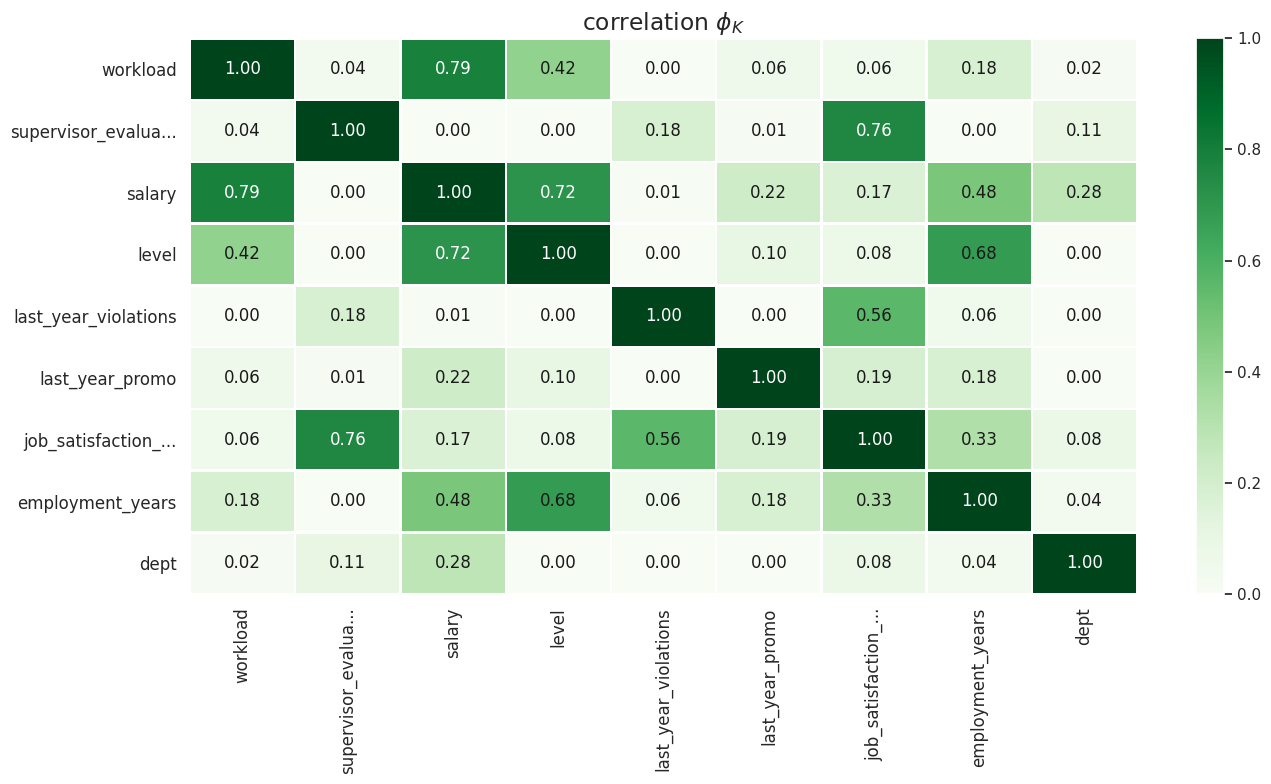

In [12]:
interval_cols = df_train_job_satisfaction_rate.select_dtypes(include=np.number).columns.difference(['id'])
phik_overview = phik_matrix(df_train_job_satisfaction_rate[df_train_job_satisfaction_rate.columns.difference(['id'])], interval_cols=list(interval_cols))

display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(14, 8)
)


Фик матрица показала следующие корреляционные соотношения между параметрами:
- workload и salary - это объясняется тем, что большая нагрузка на сотрудника обычно сопровождается ростом его зарплаты
- salary и level - чем выше Level сотрудника тем выше его зарплата
- supervisor_evaluation и job_satisfaction_rate - чем выше оценка супервизора - тем выше его уровень удовлетворенности работой
- level и employment_years - level сотрудника зависит от количества проработанных лет

В целом корреляционная матрица не показала каких либо исключительных ситуаций - все более менее объяснимо. Есть корреляция между некоторыми входными параметрами и целевым - нo не для всех входных параметров.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Верно!👍:\
</b> Мне интересно было изучить проведенный исследовательский анализ данных, твои графики, осмысленный и красочный графический анализ. Найдены очень интересные закономерности)

### Подготовка данных

Делаем merge двух датафреймов df_test_features и df_test_target_job_satisfaction_rate для формирования тестового датафрейма df_test_all, который будет содержать входные и целевой тестовые признаки. Объединение выполняем как LEFT JOIN по общей колонке id, так как у правого датафрейма строк больше так как мы ранее удаляли NaN у левого датафрейма.

In [13]:
df_test_all  = df_test_features.merge(df_test_target_job_satisfaction_rate, left_on='id', right_on='id', how='left')
display(df_test_all.head())
df_test_features.info()
df_test_all.info()
df_test_target_job_satisfaction_rate.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     1998 non-null   int64 
 1   dept                   1996 non-null   string
 2   level                  1997 non-null   string
 3   workload               1998 non-null   string
 4   employment_years       1998 non-null   string
 5   last_year_promo        1998 non-null   string
 6   last_year_violations   1998 non-null   string
 7   supervisor_evaluation  1998 non-null   string
 8   salary                 1998 non-null   int64 
dtypes: int64(2), string(7)
memory usage: 156.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998 entries, 0 to 1997
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1998 non-null   int64  
 1   dept          

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Хорошо, что объединение происходит по id

 Далее формируем датафреймы X_train, X_test, y_train, y_test на основе датафреймов df_train_job_satisfaction_rate и df_test_all

In [14]:
df_train_job_satisfaction_rate.columns.difference(['id'])

Index(['dept', 'employment_years', 'job_satisfaction_rate', 'last_year_promo',
       'last_year_violations', 'level', 'salary', 'supervisor_evaluation',
       'workload'],
      dtype='object')

In [15]:
print(f'Количество дубликтов: df_train_job_satisfaction_rate: {df_train_job_satisfaction_rate.duplicated(subset="id").sum()}')
print(f'Количество дубликтов: df_train_job_satisfaction_rate: {df_train_job_satisfaction_rate.duplicated(subset=df_train_job_satisfaction_rate.columns.difference(["id"])).sum()}')

Количество дубликтов: df_train_job_satisfaction_rate: 0
Количество дубликтов: df_train_job_satisfaction_rate: 245


In [16]:
def fillna_with_mode(df):
    for col in list(df.select_dtypes(exclude=np.number)):
        if df[col].isna().sum() > 0:
          moda = df[col].mode()[0]
          df[col].fillna(moda, inplace = True)

print(df_test_all.isna().sum())
fillna_with_mode(df_test_all)
print(df_test_all.isna().sum())

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


In [17]:
X_train = df_train_job_satisfaction_rate.drop(['job_satisfaction_rate','id'], axis=1).replace({pd.NA: np.nan})
y_train = df_train_job_satisfaction_rate['job_satisfaction_rate']
X_test = df_test_all.drop(['job_satisfaction_rate','id'], axis=1).replace({pd.NA: np.nan})
y_test = df_test_all['job_satisfaction_rate']

Ранее мы удалили признак id с неповторяющимися значениями

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Я не совсем понял о чем тут речь? Я проверяю только на дубликаты по id и считаю что в таблице не может быть более одной записи с одним и тем же id. Я проверил вначале - это подтвердилось. Если я удалю один или несколько rows из этой таблицы то данное условие не будет нарушено так как новые записи в таблицу не будут при этом добавляться. Дубликаты по всем остальным полям кроме id меня в данной парадигме не интересуют (я специально выше проверил такие в таблице train есть) - так как вполне возможно что у двух разных пользователей будет один и тот же набор параметров и я не считаю это ошибкой в данном случае. Предположение что что такие дубликаты могут портить модель - не подтвердилось так как я именно на таких данных получил значение метрик в нужных диапазонах. Твое утверждение было бы верным если бы я удалял признаки у DF и в этом случае можно было бы прийти к появлению новых полных дубликатов (не включая ID) так как количество признаков уменьшается - Но я этого в данном случае не делаю. Резюмируя - проверка показала что записей с одинаковыми ID нет и мне не надо удалять дубликаты. v.2".
</div>

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера    <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b> 
    
Ранее мы удалили признак `id` с неповторяющимися значениями, после удаления id нам нужно проверить наличие новых дубликатов в данных: так как мы удалили часть лишних признаков, у нас могут появиться новые явные дубликаты: чем меньше признаков остаётся, тем выше шанс, что значения остальных признаков будут пересекаться. При этом ценности для модели такие наблюдения уже не принесут, поэтому стоит проверить дубликаты также в финальной версии таблицы.
    
При этом важно проверить только `train`: наличие дубликатов в `test` нам никак не мешает, но это правильное решение с точки зрения неприкосновенности `test`, ведь реальный поток данных (который имитирует `test` выборка) мы исправить не сможем. А вот наличие дубликатов в `train` не только не принесёт пользы модели, но может и навредить

In [18]:
num_columns = list(X_train.select_dtypes(include=np.number))
cat_columns = list(X_train.select_dtypes(exclude=np.number))
ord_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
ohe_columns = ['employment_years', 'supervisor_evaluation']

print(ohe_columns)
print(num_columns)

ohe_pipe = Pipeline(
    [
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('ohe', OrdinalEncoder())
    ]
    )

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

['employment_years', 'supervisor_evaluation']
['salary']


<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Добавил OrdinalEncoder для ряда cat колонок (это было в требованиях - просмотрел) и добавил SimpleImputer со стратегией замены NaN на моду - на результаты по старой методике это не повлияло - что подтверждают мою гипотезу что количество пропусков настолько мало - что их можно либо отбрасывать либо заменять на моду -  результат это не меняет. C тестовой выборкой сложнее - там у меня не получилось взять best_estimator и от него взять ColumnTransformer и от него уже дернуть только один  SimpleImputer не исопльзуя другие трансформеры. Если я возьму и вызову transform от best_estimator ColumnTransformer - то этот метод применится ко всем степам этого трансформера а мне нужен только SimpleImputer и я не понял как взять только один SimpleImputer степ - провозился с этим полдня и решения не нашел. Поэтому для test выборки использовал метод грубой силы и просто вызвыл метод fillna с заменой на моду для каждой cat колонки - на результаты это не повлияет и я выполнил требование заказчика использовать обработку пропусков в пайплайне (частично только для train выборки) v.2".
</div>

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера    <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>

По условию задачи нужно использовать как минимум два готовых энкодера, например OneHotEncoder и OrdinalEncoder

### Обучение моделей

In [19]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_pred) + np.abs(y_true))/2))

smape_scorer = make_scorer(smape, greater_is_better=False)

pipe_final = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

  #       # словарь для модели KNeighborsClassifier() 
  #  {
  #      'models': [KNeighborsRegressor()],
  #      'models__n_neighbors': range(2, 6),
  #      'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
  #  },

    {
        'models': [SVR(C=1.0, epsilon=0.05)],
        'models__degree': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

result = pd.DataFrame(grid_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_


transformer = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1][0]
print(grid_search.best_estimator_.named_steps['preprocessor'].transformers_)
print(grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0])
print(grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1])
print(grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1][0])


# Оцениваем качество на тестовой выборке
y_pred_test = best_model.predict(X_test)
smape_test = smape(y_test, y_pred_test)


print ('Лучшая модель и её параметры:\n', grid_search.best_estimator_)
print ('Метрика SMAPE лучшей модели на тренировочной выборке:', grid_search.best_score_)
print ("Метрика SMAPE лучшей модели на тестовой выборке:", smape_test)

,rank_test_score,param_models,mean_test_score,params
54,1,"SVR(degree=2, epsilon=0.05)",-14.222022,"{'models': SVR(degree=2, epsilon=0.05), 'models__degree': 3, 'preprocessor__num': StandardScaler()}"
63,1,"SVR(degree=2, epsilon=0.05)",-14.222022,"{'models': SVR(degree=2, epsilon=0.05), 'models__degree': 6, 'preprocessor__num': StandardScaler()}"
60,1,"SVR(degree=2, epsilon=0.05)",-14.222022,"{'models': SVR(degree=2, epsilon=0.05), 'models__degree': 5, 'preprocessor__num': StandardScaler()}"
51,1,"SVR(degree=2, epsilon=0.05)",-14.222022,"{'models': SVR(degree=2, epsilon=0.05), 'models__degree': 2, 'preprocessor__num': StandardScaler()}"
57,1,"SVR(degree=2, epsilon=0.05)",-14.222022,"{'models': SVR(degree=2, epsilon=0.05), 'models__degree': 4, 'preprocessor__num': StandardScaler()}"
...,...,...,...,...
56,62,"SVR(degree=2, epsilon=0.05)",-39.510618,"{'models': SVR(degree=2, epsilon=0.05), 'models__degree': 3, 'preprocessor__num': 'passthrough'}"
59,62,"SVR(degree=2, epsilon=0.05)",-39.510618,"{'models': SVR(degree=2, epsilon=0.05), 'models__degree': 4, 'preprocessor__num': 'passthrough'}"
62,62,"SVR(degree=2, epsilon=0.05)",-39.510618,"{'models': SVR(degree=2, epsilon=0.05), 'models__degree': 5, 'preprocessor__num': 'passthrough'}"
53,62,"SVR(degree=2, epsilon=0.05)",-39.510618,"{'models': SVR(degree=2, epsilon=0.05), 'models__degree': 2, 'preprocessor__num': 'passthrough'}"


[('ohe', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(drop='first', sparse=False))]), ['employment_years', 'supervisor_evaluation']), ('ord', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OrdinalEncoder())]), ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']), ('num', StandardScaler(), ['salary'])]
('ohe', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(drop='first', sparse=False))]), ['employment_years', 'supervisor_evaluation'])
Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(drop='first', sparse=False))])
SimpleImputer(strategy='most_frequent')
Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
           

### Выводы

Лучший результат показала модель SVR (при выборе из вариантов SVR, LinearRegression и DecisionTreeRegressor) со значением метрики SMAPE для тренировочной выборки = -14.22. Данная модель была проверена на тестовой выборке с значением метрики SMAPE =  13.45


<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Разумеется у меня ошибка - деление на 2 не в скобках. Исправил и метрика сразу уползла вверх за 15. Сначала поиграл с удалением входных признаков - метрику только увеличило. Потом добавил еще одну модель SVR и поигрался еще с ее гиперпараметрами и вышел в итоге на приемлемую величину метрики v.2".
</div>

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
    
Здесь есть ошибка: в функции невзвешенной `smape`(деление на 2 и скобки)

</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Верно, что задаешь параметр `greater_is_better=False`. Дело в том, что разработчики пакета `sklearn` при создании функций `cross_val_score` и `GridSearchCV` утвердили соглашение: возвращаемые результаты вычислений данных функций должны соответствовать задаче максимизации (чем большее значение метрики получаем, тем лучше). При этом обратная задача минимизации может быть осуществлена через максимизацию метрики, домноженной на -1. Об этом можно чуть подробнее почитать в документации пакета, правда она на английском. Оставлю <a href = 'https://scikit-learn.org/stable/modules/model_evaluation.html'>ссылку</a>. 

## Задача 2: предсказание увольнения сотрудника из компании

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
В этой задаче по аналогичным заданиям и действиям в проекте -  аналогичные замечания (я их привел выше в первой части проекта), без исправления которых проект принят не будет.
        
Новые неповторяющиеся замечания будут даны ниже отдельно   

### Загрузка данных

In [20]:
df_train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
display(df_train_quit.head(5))
df_train_quit.info()


df_test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
display(df_test_target_quit.head(5))
df_test_target_quit.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Выводы по результатам осмотра данных:
- в таблицах df_train_quit, df_test_target_quit присутствует колонка id, которая является идентификатором клиента а также ряд полей тпа int, float, object
- в таблицах df_train_quit, df_test_target_quit  есть небольшое пропусков нет
- название полей при импорте из файла сформированы латиницей snake case - и не требуют переименования
- типы колонок соответствуют их содержимомму - но возможно далее надо будет перевести тип object в string для большей компактности

### Предобработка данных

Значений категорий равных NaN или пробел в датафреймах df_train_quit и df_test_target_quit не обнаружено.
Исправлена грамматическая ошибка для значения категории *sinior* на *senior* для колонки df_train_quit['level']

In [21]:
display(df_train_quit['dept'].value_counts())
display(df_train_quit['level'].value_counts())
display(df_train_quit['workload'].value_counts())
display(df_train_quit['last_year_promo'].value_counts())
display(df_train_quit['last_year_violations'].value_counts())
display(df_train_quit['quit'].value_counts())
df_train_quit['level'] = df_train_quit['level'].replace('sinior', 'senior')
display(df_train_quit['level'].value_counts())


sales         1438
technology    928 
purchasing    588 
marketing     582 
hr            464 
Name: dept, dtype: int64

junior    1949
middle    1694
sinior    357 
Name: level, dtype: int64

medium    2118
low       1208
high      674 
Name: workload, dtype: int64

no     3887
yes    113 
Name: last_year_promo, dtype: int64

no     3455
yes    545 
Name: last_year_violations, dtype: int64

no     2872
yes    1128
Name: quit, dtype: int64

junior    1949
middle    1694
senior    357 
Name: level, dtype: int64

Других аномалий не обнаружено. Изменен тип всех колонок с object на string для датафреймов df_train_quit и df_test_target_quit

In [22]:
df_train_quit_str_col_list = df_train_quit.select_dtypes(exclude=np.number).columns
df_train_quit[df_train_quit_str_col_list] = \
  df_train_quit[df_train_quit_str_col_list].astype('string')
df_train_quit.info()

df_test_target_quit_str_col_list = df_test_target_quit.select_dtypes(exclude=np.number).columns
df_test_target_quit[df_test_target_quit_str_col_list] = \
  df_test_target_quit[df_test_target_quit_str_col_list].astype('string')
df_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   string
 2   level                  4000 non-null   string
 3   workload               4000 non-null   string
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   string
 6   last_year_violations   4000 non-null   string
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   string
dtypes: int64(4), string(6)
memory usage: 312.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    200

Колонки employment_years и supervisor_evaluation для df_train_quit датафрейма надо перевести в категориальный формат, так как их значения представляют собой целые числа и они занимают отоносительно небольшой диапазон

In [23]:
df_train_quit[['employment_years', 'supervisor_evaluation']] = \
  df_train_quit[['employment_years', 'supervisor_evaluation']].astype('string')
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   string
 2   level                  4000 non-null   string
 3   workload               4000 non-null   string
 4   employment_years       4000 non-null   string
 5   last_year_promo        4000 non-null   string
 6   last_year_violations   4000 non-null   string
 7   supervisor_evaluation  4000 non-null   string
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   string
dtypes: int64(2), string(8)
memory usage: 312.6 KB


### Исследовательский анализ данных

#### Построение гистограмм, boxplots и корреляционной матрицы

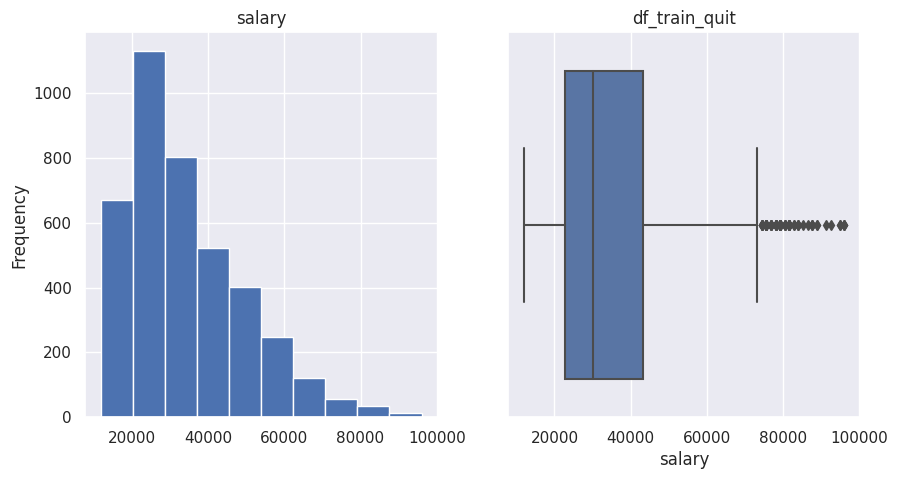

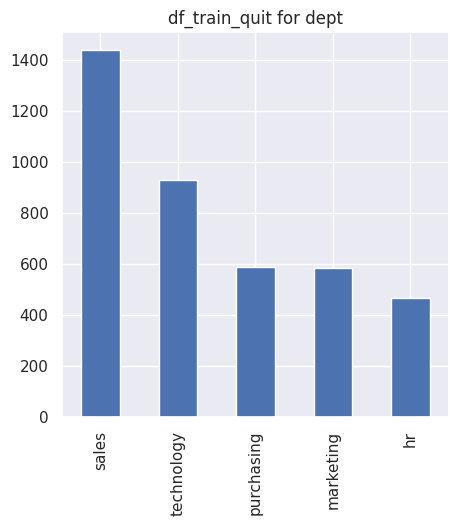

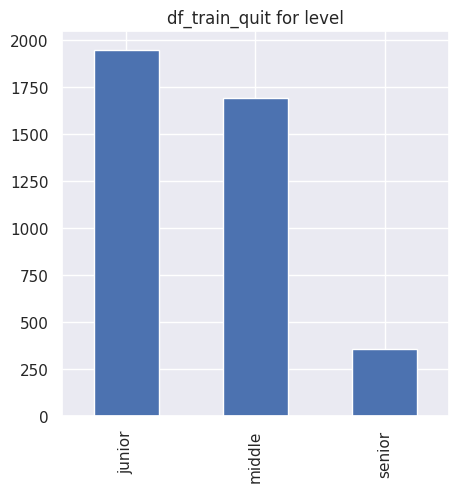

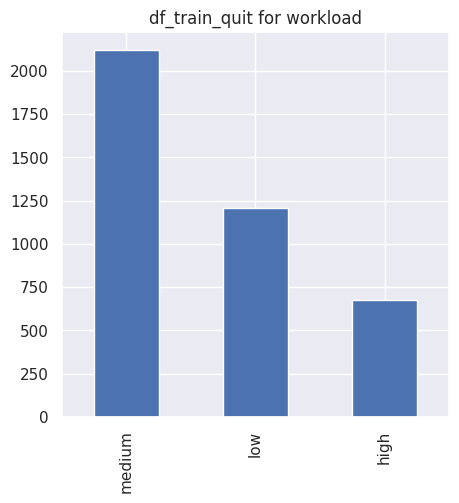

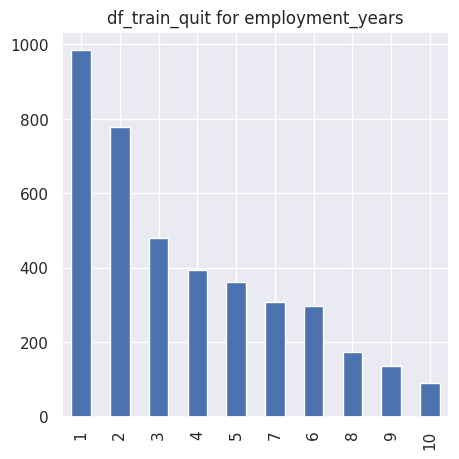

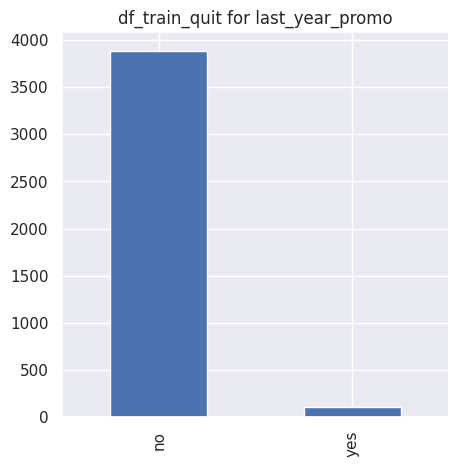

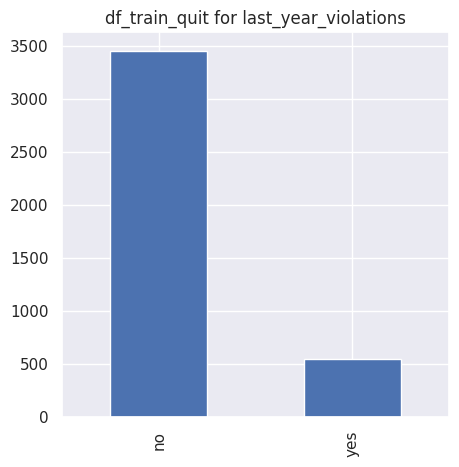

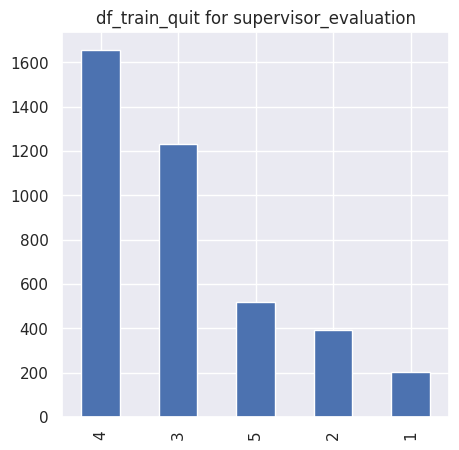

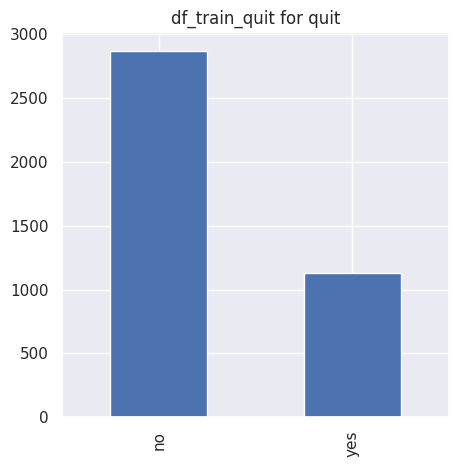

,dept,employment_years,last_year_promo,last_year_violations,level,quit,salary,supervisor_evaluation,workload
dept,1.000000,0.000000,0.000000,0.044274,0.000000,0.000000,0.280300,0.042772,0.000000
employment_years,0.000000,1.000000,0.156494,0.000000,0.692676,0.659093,0.491915,0.000000,0.213013
last_year_promo,0.000000,0.156494,1.000000,0.000000,0.110585,0.157370,0.215043,0.032376,0.044388
last_year_violations,0.044274,0.000000,0.000000,1.000000,0.000000,0.185071,0.086087,0.179228,0.014063
level,0.000000,0.692676,0.110585,0.000000,1.000000,0.312799,0.745104,0.007189,0.479480
quit,0.000000,0.659093,0.157370,0.185071,0.312799,1.000000,0.564154,0.245489,0.132243
salary,0.280300,0.491915,0.215043,0.086087,0.745104,0.564154,1.000000,0.055330,0.793876
supervisor_evaluation,0.042772,0.000000,0.032376,0.179228,0.007189,0.245489,0.055330,1.000000,0.000000
workload,0.000000,0.213013,0.044388,0.014063,0.479480,0.132243,0.793876,0.000000,1.000000


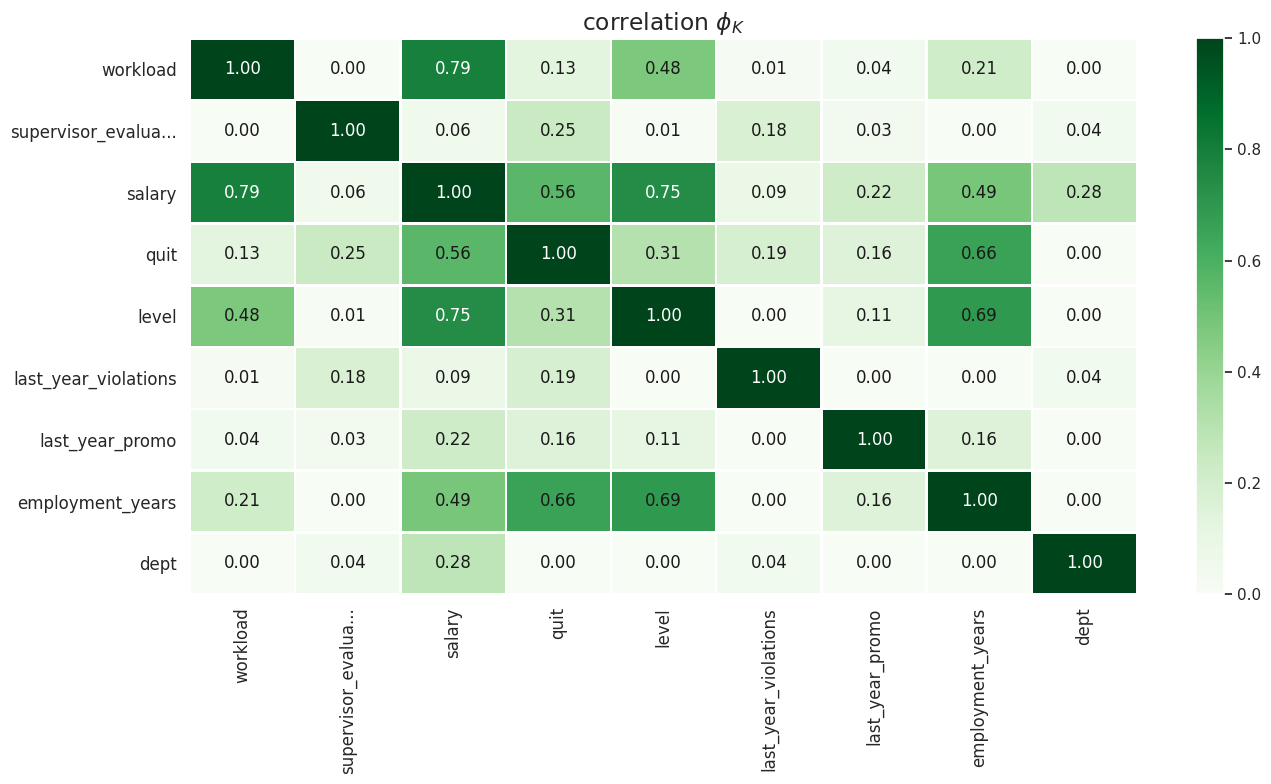

In [24]:
plot_sub_plot_hist_boxplot(df_train_quit.select_dtypes(include=np.number), 'df_train_quit')
plot_bar_plot_for_columns(df_train_quit.select_dtypes(exclude=np.number), 'df_train_quit')

interval_cols = df_train_quit.select_dtypes(include=np.number).columns.difference(['id'])
phik_overview = phik_matrix(df_train_quit[df_train_quit.columns.difference(['id'])], interval_cols=list(interval_cols))

display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(14, 8)
)

Анализ гистограмм, boxplots, bar диаграмм и корреляционной матрицы не показал отличий от результатов анализа для Задачи 1, произведенного ранее.

#### Составление портрета «уволившегося сотрудника»

При составлении диаграмм для портрета «уволившегося сотрудника» все значения по оси Y будут нормироваться на общее количество сотрудников и выводиться в процентах от общего числа

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
4,910140,marketing,junior,medium,2,no,no,5,25200,no
6,417070,technology,middle,medium,8,no,no,2,44400,no


/tmp/ipykernel_1083/2936067901.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x / normalizer) for x in vals])


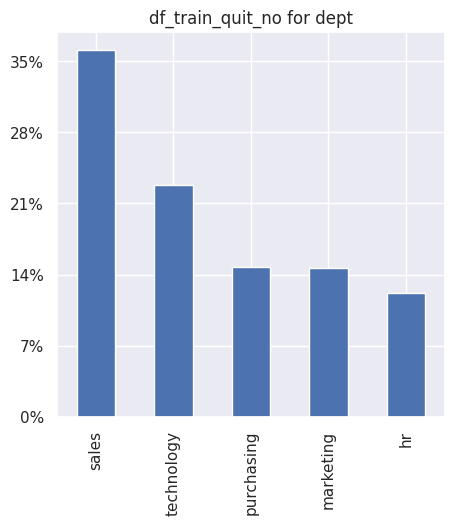

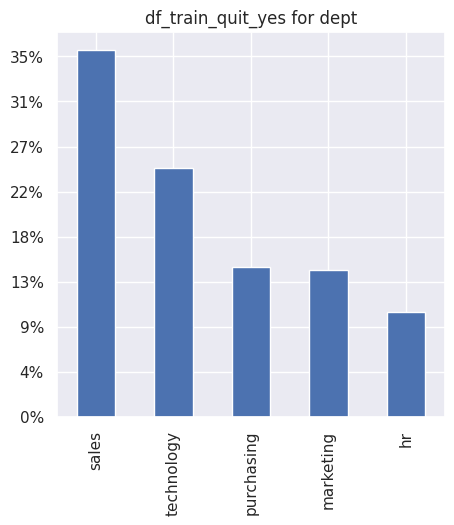

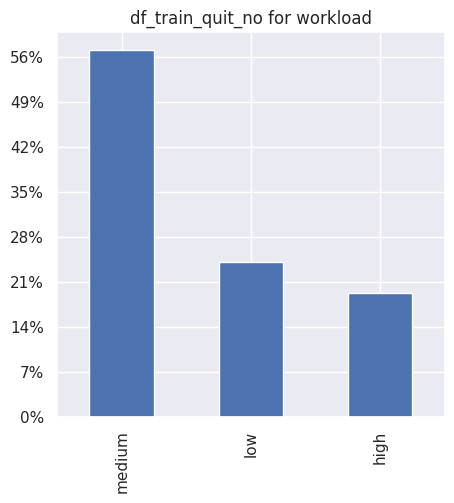

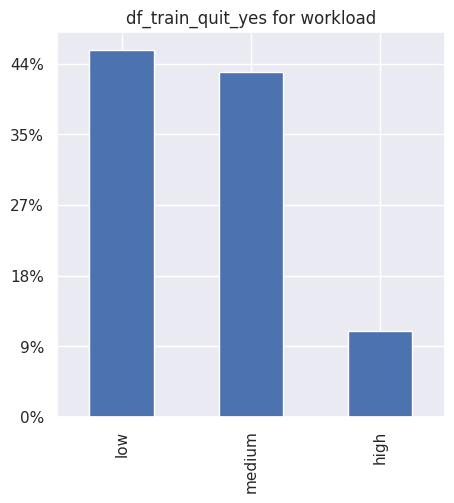

Mean salary for non-quit employees=37702.22841225627
Mean salary for quit employees=23885.106382978724


In [25]:
df_train_quit_yes = df_train_quit[df_train_quit['quit'] == 'yes']
df_train_quit_no = df_train_quit[df_train_quit['quit'] == 'no']
display(df_train_quit_no.head())

plot_bar_plot_for_columns(df_train_quit_no[['dept']], 'df_train_quit_no', df_train_quit_no['dept'].count())
plot_bar_plot_for_columns(df_train_quit_yes[['dept']], 'df_train_quit_yes', df_train_quit_yes['dept'].count())

plot_bar_plot_for_columns(df_train_quit_no[['workload']], 'df_train_quit_no', df_train_quit_no['workload'].count())
plot_bar_plot_for_columns(df_train_quit_yes[['workload']], 'df_train_quit_yes', df_train_quit_yes['workload'].count())

salary_mean_quit_no = df_train_quit_no['salary'].mean()
salary_mean_quit_yes = df_train_quit_yes['salary'].mean()

print(f'Mean salary for non-quit employees={salary_mean_quit_no}')
print(f'Mean salary for quit employees={salary_mean_quit_yes}')


Анализ датафреймов для действующих и уволившихся сотрудников показал, что:
- распределение по отделам для обоих сетов примерно одинаков и максимальное число сотрудников - в отделе sales
- распределение по нагрузке отличается для этих двух сетов - для действующих сотрудников максимальное количество имеет нагрузку medium = 44% от общего числа работающих сотрудников, для уволившихся - нагрузку low, medium ~ 44% от общего числа уволившихся сотрудников
- сравнение средней зарплаты показало что средняя зарплата для уволившихся сотрудников ниже и равна 23885

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Добавил параметр для нормализации на общее число сотрудников данного типа в функции вывода bar диаграмм v.2".
</div>

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
    
Нужно еще использовать относительные значения в описании портрета уволившегося сотрудника, прописать долю ушедших сотрудников

#### Проверка утверждения что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
quit                     0
dtype: int64

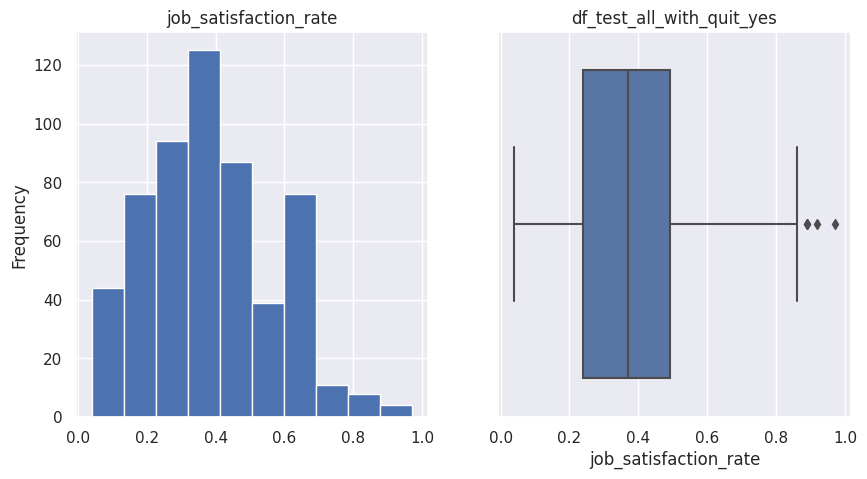

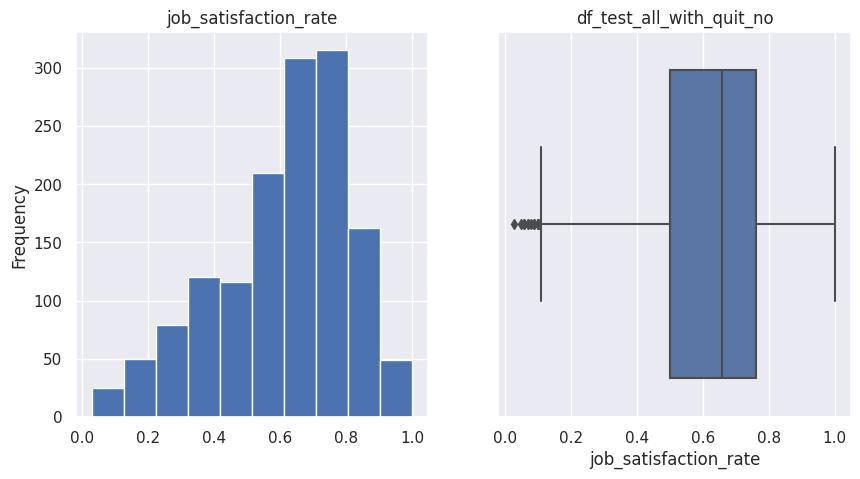

,dept,employment_years,job_satisfaction_rate,last_year_promo,last_year_violations,level,quit,salary,supervisor_evaluation,workload
dept,1.000000,0.000000,0.071902,0.000000,0.000000,0.000000,0.000000,0.330155,0.057920,0.032464
employment_years,0.000000,1.000000,0.313962,0.173776,0.067000,0.690022,0.605930,0.494822,0.000000,0.202388
job_satisfaction_rate,0.071902,0.313962,1.000000,0.336964,0.554651,0.097392,0.609973,0.171127,0.769808,0.051919
last_year_promo,0.000000,0.173776,0.336964,1.000000,0.000000,0.118301,0.137971,0.193873,0.011452,0.035653
last_year_violations,0.000000,0.067000,0.554651,0.000000,1.000000,0.017655,0.174401,0.000000,0.189586,0.000000
level,0.000000,0.690022,0.097392,0.118301,0.017655,1.000000,0.294109,0.748979,0.002556,0.474694
quit,0.000000,0.605930,0.609973,0.137971,0.174401,0.294109,1.000000,0.508064,0.294485,0.102067
salary,0.330155,0.494822,0.171127,0.193873,0.000000,0.748979,0.508064,1.000000,0.114621,0.785783
supervisor_evaluation,0.057920,0.000000,0.769808,0.011452,0.189586,0.002556,0.294485,0.114621,1.000000,0.036789
workload,0.032464,0.202388,0.051919,0.035653,0.000000,0.474694,0.102067,0.785783,0.036789,1.000000


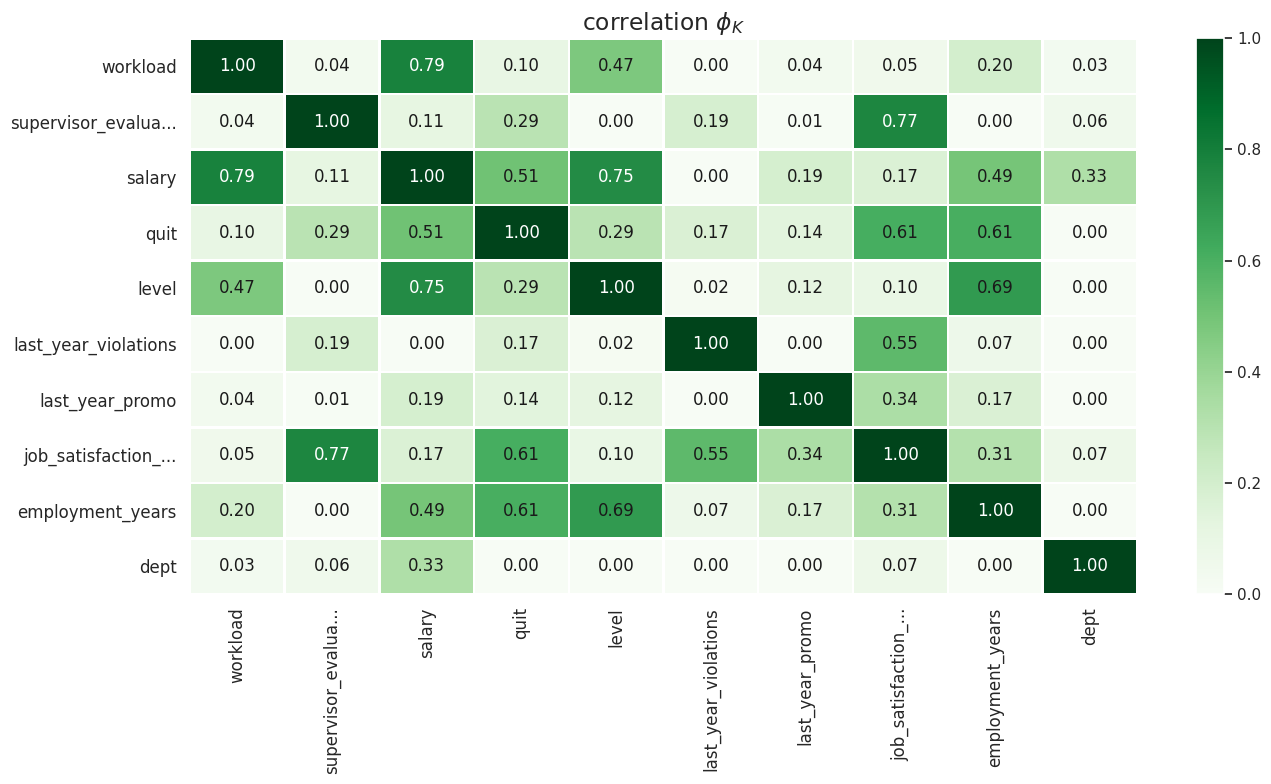

In [26]:
df_test_all_with_quit = df_test_all.merge(df_test_target_quit, left_on='id', right_on='id', how='left')
display(df_test_all_with_quit.isna().sum())
df_test_all_with_quit.head()
df_test_all_with_quit_yes = df_test_all_with_quit[df_test_all_with_quit['quit'] == 'yes']
df_test_all_with_quit_no = df_test_all_with_quit[df_test_all_with_quit['quit'] == 'no']

plot_sub_plot_hist_boxplot(df_test_all_with_quit_yes[['job_satisfaction_rate']], 'df_test_all_with_quit_yes')
plot_sub_plot_hist_boxplot(df_test_all_with_quit_no[['job_satisfaction_rate']], 'df_test_all_with_quit_no')

interval_cols = df_test_all_with_quit.select_dtypes(include=np.number).columns.difference(['id'])
phik_overview = phik_matrix(df_test_all_with_quit[df_test_all_with_quit.columns.difference(['id'])], interval_cols=list(interval_cols))

display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(14, 8)
)

Проверка корреляции между признаком job_satisfaction_rate и признаком того, уволился сотрудник или нет, показала, что:
- для уволившихся сотрудников медиана распределения признака job_satisfaction_rate смещена в сторону меньших значений и находится на уровне 0.3 - по сравнению с значением 0.8 для действующих сотрудников
- для обоих распределений есть некоторое количество выбросов - у уволившихся сотрудников выбросы в стороне больших значений, у действующих - в стороне меньших
- коэффициент корреляции между признаками job_satisfaction_rate и quit равен 0.61 - я не считаю значение этого коэффициента достаточным для того, чтобы считать эти признаки коррелируемыми

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>  
    
Хорошо. Добавлю, что сравнение распределений признака job_satisfaction_rate для ушедших и оставшихся работников можно провести с использованием стат теста

### Добавление нового входного признака

Новый входной признак не был добавлен, так как предыдущий анализ не показал достаточной корреляции между признаками job_satisfaction_rate и quit

### Подготовка данных

Формируем датафреймы X_train, X_test, y_train, y_test на основе датафреймов df_train_quit и df_test_all_with_quit

In [27]:
X_train = df_train_quit.drop(['quit','id'], axis=1)
y_train = df_train_quit['quit']
X_test = df_test_all_with_quit.drop(['job_satisfaction_rate','id', 'quit'], axis=1)
y_test = df_test_all_with_quit['quit']

Далее формируем списки для скейлеров OneHotEncoder и MinMaxScaler и формируем ColumnTransformer для этих скейлеров для использования в пайплайне

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Добавил OrdinalEncoder для ряда cat колонок по аналогии с Задачей 1 и не добавил SimpleImputer так как в train выборке тут нет пропусков. Тестовую выборку сформировал из датафрейма df_test_all_with_quit где ранее все пропуски уже были удалены на этапе Задачи 1 v.2".
</div>

In [28]:
num_columns = list(X_train.select_dtypes(include=np.number))
ord_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
ohe_columns = ['employment_years', 'supervisor_evaluation']

ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [
     ('ohe', OrdinalEncoder())
    ]
    )

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение моделей

Обучаем на трех моделях с вариацией гиперпараметров для каждой модели:
- DecisionTreeClassifier
- LogisticRegression
- KNeighborsClassifier

In [29]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

custom_scorer = make_scorer(roc_auc_score, greater_is_better=True,  needs_threshold = True)

param_grid = [
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

result = pd.DataFrame(grid_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
 
print ('Лучшая модель и её параметры:\n', grid_search.best_estimator_)
print ('Метрика roc_auc_score лучшей модели на тренировочной выборке:', grid_search.best_score_)

# Оцениваем качество на тестовой выборке
#y_pred_test = best_model.predict(X_test)

y_pred = best_model.predict_proba(X_test)[:,1]
roc_auc_score_test = roc_auc_score(y_test, y_pred)
# Выводим значение roc_auc_score на тестовой выборке
print ("Метрика roc_auc_score лучшей модели на тестовой выборке:", roc_auc_score_test)

,rank_test_score,param_models,mean_test_score,params
59,1,"LogisticRegression(C=5, penalty='l1', random_state=42, solver='liblinear')",0.931339,"{'models': LogisticRegression(C=5, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 5, 'preprocessor__num': 'passthrough'}"
56,2,"LogisticRegression(C=5, penalty='l1', random_state=42, solver='liblinear')",0.931337,"{'models': LogisticRegression(C=5, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 4, 'preprocessor__num': 'passthrough'}"
62,3,"LogisticRegression(C=5, penalty='l1', random_state=42, solver='liblinear')",0.931337,"{'models': LogisticRegression(C=5, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 6, 'preprocessor__num': 'passthrough'}"
53,4,"LogisticRegression(C=5, penalty='l1', random_state=42, solver='liblinear')",0.931300,"{'models': LogisticRegression(C=5, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 3, 'preprocessor__num': 'passthrough'}"
57,5,"LogisticRegression(C=5, penalty='l1', random_state=42, solver='liblinear')",0.931244,"{'models': LogisticRegression(C=5, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 5, 'preprocessor__num': StandardScaler()}"
...,...,...,...,...
7,61,DecisionTreeClassifier(random_state=42),0.659406,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 4, 'preprocessor__num': MinMaxScaler()}"
6,61,DecisionTreeClassifier(random_state=42),0.659406,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 4, 'preprocessor__num': StandardScaler()}"
5,64,DecisionTreeClassifier(random_state=42),0.634799,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': 'passthrough'}"
4,64,DecisionTreeClassifier(random_state=42),0.634799,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': MinMaxScaler()}"


Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['employment_years',
                                                   'supervisor_evaluation']),
                                                 ('ord',
                                                  Pipeline(steps=[('ohe',
                                                                   OrdinalEncoder())]),
                                                  ['dept', 'level', 'workload',
                                                   'last_year_promo',
                                 

### Выводы

Лучший результат показала модель LogisticRegression (при выборе из вариантов DecisionTreeClassifier, KNeighborsClassifier и LogisticRegression) со значением метрики roc_auc_score = 0.93. Данная модель была проверена на тестовой выборке с значением метрики = 0.92


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Тестирование лучшей модели проведено правильно

## Общие выводы 

### Описание задачи

На основании данных о сотрудниках организации необходимо построить две модели:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Кроме того, необходимо описать портрет «уволившегося сотрудника» - то есть указать признаки, характерные для таких сотрудников.

### Описание этапов работы

- Загрузка данных - загрузка данных из CSV файлов в датафреймы
- Предобработка данных - проверка данных на пропуски, дубликаты, опечатки
- Исследовательский анализ данных - построение гистограмм, boxplots, bar-диаграмм, корреляционых матриц
- Подготовка данных - merge датафреймов в один, формирование ColumnTransformer для пайплайна
- Обучение моделей - формирование пайплайна из ColumnTransformer и необходимого набора моделей, запуск пайплайна, определение лучшей модели через кросс-валидацию для данной метрики, проверка выбранной метрики на тестовых данных

### Выводы и дополнительные предложения для бизнеса

Построены две модели, которые уверенно предсказывают целевые параметры *job_satisfaction_rate* и *quit* для данных по сотрудникам организации.
Анализ данных показал, что параметр *job_satisfaction_rate* ниже для сотрудников, которые уже уволились, по сравнению с действующими сотрудниками. Кроме того, средняя заработная плата для уволившихся сотрудников ниже, чем для действующих и нагрузка для уволившихся сотрудников в большей степени находится в диапазоне ['low', 'medium']. Отсюда следуют следующие рекомендации для бизнеса для предотвращения увольнения сотрудников из организации:
- повышать заработную плату сотрудникам - с переводом уровня нагрузки в 'high'
- стремиться к увеличения параметра *job_satisfaction_rate*

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Молодец, что не забываешь про итоговый вывод и рекомендации для бизнеса

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера (общий вывод по проекту) <a class="tocSkip"> </h2>    
    
  
У меня сложилось хорошее общее впечатление о проекте, тебе удалось неплохо справиться с этим проектом. Молодец! Подготовлены данные для анализа, изучен каждый параметр. Все красиво визуализировано, построено несколько моделей регрессии/ классификации и оценено их качество. Осмысленная аналитика и дельная модельная работа - многое удалось как надо)
    
Отмечу отдельные положительные моменты проекта🙂:
    
- в ходе проекта встречались  функции, помогающие избавиться от дублирования кода;
- много красивых визуализаций в проекте и хорошая интерпретация;
- при обучении моделей использованы пайплайны, кросс-валидация и поиск гиперпараметров.
    
Есть несколько моментов всего, на которые стоит ещё раз взглянуть, я указал их в моих комментариях по ходу проекта. Предлагаю тебе доработать проект по моим комментариям, чтобы довести его до совершенства.

    
 
</div>